Test different DKI fit strategies and analyse MK changes with increase of crossing fibers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import matplotlib
%matplotlib inline

# To sample the diffusion-weighted directions
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

# To reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# To perform the monte-carlo simulations
from dipy.sims.voxel import multi_tensor

# Usefull dti functions
from dipy.reconst.dti import design_matrix as dti_design_matrix
from dipy.reconst.dti import (mean_diffusivity, fractional_anisotropy,
                              decompose_tensor, from_lower_triangular,
                              lower_triangular, mean_diffusivity)
import dipy.reconst.dti as dti
from dipy.reconst.vec_val_sum import vec_val_vect

# To process the standard diffusion kurtosis imaging
from dipy.reconst.utils import dki_design_matrix
import dipy.reconst.dki as dki

from dki_alternative import (ols_dki_df, nls_dki_df, avs_dki_df)

Define acquisition parameters

In [2]:
# ------------- acquisition parameters - dataset 1 --------------
# 30 b0
# 30 b-value = 1000
# 30 b-value = 2000
# ---------------------------------------------------------------

SNR = None

# Sample 30 diffusion-weighted directions
theta = np.pi * np.random.rand(30)
phi = 2 * np.pi * np.random.rand(30)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions30 = hsph_updated.vertices # directions for each shell

# Create full dataset parameters
bvals = np.hstack((np.zeros(30), 1000 * np.ones(30),
                   2000 * np.ones(30)))
bvecs = np.vstack((np.zeros((30, 3)), directions30, directions30))
gtab = gradient_table(bvals, bvecs)

# Design matrices
dti_matrix = dti_design_matrix(gtab)
dki_matrix = dki_design_matrix(gtab)

Generate simulations

In [3]:
# ---------------------------------------------------------------
# Generate simulations
# ---------------------------------------------------------------

Cross_angle = np.linspace(0, 90, num=91)

FSF = np.linspace(0.1, 0.9, num=5)
ADr = 0.99e-3
RDr = 0.00e-3
ADh = 2.26e-3 
RDh = 0.87e-3

mevals = np.array([[ADr, RDr, RDr],
                   [ADh, RDh, RDh],
                   [ADr, RDr, RDr],
                   [ADh, RDh, RDh]])

nrep = 1  # number of simulation repetitions
DWI_simulates = np.empty((FSF.size, Cross_angle.size, nrep, bvals.size))

for fsf_i in range(FSF.size):
    fsf = FSF[fsf_i]
    for var_i in range(Cross_angle.size):
        var = Cross_angle[var_i]
        fractions = [50 * fsf, 50 * (1-fsf), 50 * fsf, 50 * (1-fsf)]
        #fractions = [fw, (100-fw) * fsf, (100-fw) * (1-fsf)]
        for s_i in range(nrep):
            signal, sticks = multi_tensor(gtab, mevals, S0=100,
                                          angles=[(0, 0), (0, 0),
                                                  (var, 0), (var, 0)],
                                          fractions=fractions, snr=SNR)
            DWI_simulates[fsf_i, var_i, s_i, :] = signal 

Process standard DKI

In [4]:
# ---------------------------------------------------------------
# standard  DKI
# ---------------------------------------------------------------
dkimodel = dki.DiffusionKurtosisModel(gtab, fit_method="WLS")
dkifit = dkimodel.fit(DWI_simulates)
fa = dkifit.fa
md = dkifit.md
mk = dkifit.mk()
ak = dkifit.ak()
rk = dkifit.rk()

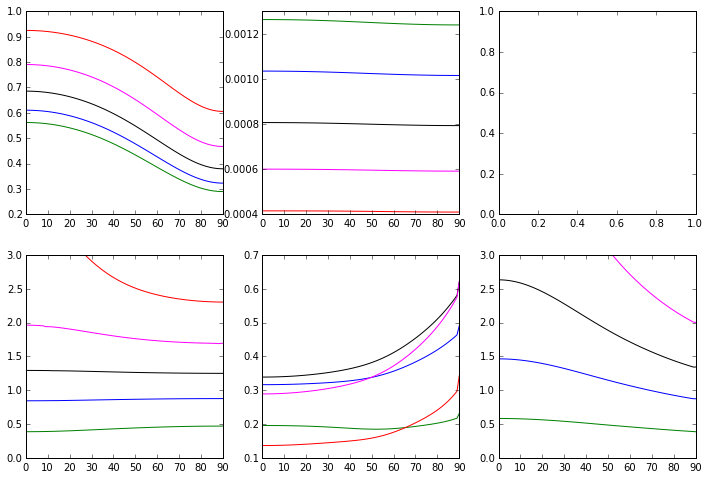

In [5]:
colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

mean_fa = np.empty(Cross_angle.size)
mean_md = np.empty(Cross_angle.size)
mean_mk = np.empty(Cross_angle.size)
mean_ak = np.empty(Cross_angle.size)
mean_rk = np.empty(Cross_angle.size)

for fsf_i in range(FSF.size):
    for var_i in range(Cross_angle.size):
        mean_fa[var_i] = np.mean(fa[fsf_i, var_i, :])
        mean_md[var_i] = np.mean(md[fsf_i, var_i, :])
        mean_mk[var_i] = np.mean(mk[fsf_i, var_i, :])
        mean_ak[var_i] = np.mean(ak[fsf_i, var_i, :])
        mean_rk[var_i] = np.mean(rk[fsf_i, var_i, :])
    axs[0, 0].plot(Cross_angle, mean_fa, color=colors[fsf_i])  
    axs[0, 1].plot(Cross_angle, mean_md, color=colors[fsf_i])  
    axs[1, 0].plot(Cross_angle, mean_mk, color=colors[fsf_i])  
    axs[1, 1].plot(Cross_angle, mean_ak, color=colors[fsf_i])  
    axs[1, 2].plot(Cross_angle, mean_rk, color=colors[fsf_i])  
        
plt.show()

Process classic MD/MK direct fit

In [6]:
params = ols_dki_df(gtab, DWI_simulates)
md_df = params[..., 0]
mk_df = params[..., 1]

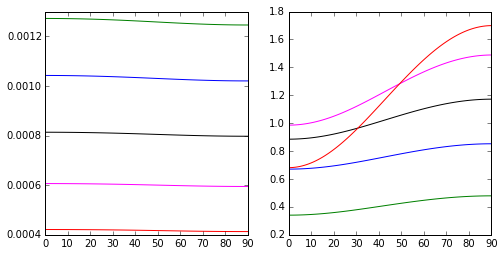

In [7]:
colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

mean_md_df = np.empty(Cross_angle.size)
mean_mk_df = np.empty(Cross_angle.size)

for fsf_i in range(FSF.size):
    for var_i in range(Cross_angle.size):
        mean_md_df[var_i] = np.mean(md_df[fsf_i, var_i, :])
        mean_mk_df[var_i] = np.mean(mk_df[fsf_i, var_i, :])
    axs[0].plot(Cross_angle, mean_md_df, color=colors[fsf_i])  
    axs[1].plot(Cross_angle, mean_mk_df, color=colors[fsf_i])

plt.show()

In [8]:
mk_df

array([[[ 0.34081164],
        [ 0.3408653 ],
        [ 0.34101704],
        [ 0.34126651],
        [ 0.34161316],
        [ 0.34205629],
        [ 0.342595  ],
        [ 0.3432282 ],
        [ 0.34395465],
        [ 0.34477296],
        [ 0.34568154],
        [ 0.34667867],
        [ 0.34776248],
        [ 0.34893096],
        [ 0.35018194],
        [ 0.35151317],
        [ 0.35292223],
        [ 0.35440662],
        [ 0.35596372],
        [ 0.35759082],
        [ 0.35928511],
        [ 0.36104371],
        [ 0.36286367],
        [ 0.36474196],
        [ 0.36667552],
        [ 0.36866121],
        [ 0.37069588],
        [ 0.37277634],
        [ 0.37489937],
        [ 0.37706175],
        [ 0.37926024],
        [ 0.38149161],
        [ 0.38375263],
        [ 0.38604012],
        [ 0.38835087],
        [ 0.39068175],
        [ 0.39302964],
        [ 0.39539146],
        [ 0.39776419],
        [ 0.40014486],
        [ 0.40253055],
        [ 0.4049184 ],
        [ 0.40730561],
        [ 0

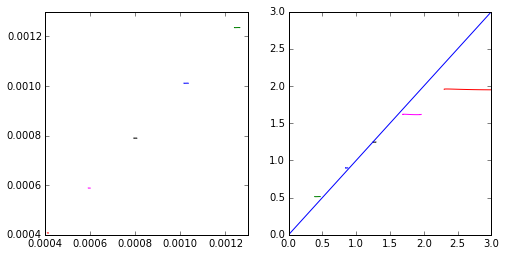

In [110]:
colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

mean_md_df = np.empty(Cross_angle.size)
mean_mk_df = np.empty(Cross_angle.size)

for fsf_i in range(FSF.size):
    for var_i in range(Cross_angle.size):
        mean_md_df[var_i] = np.mean(md_df[fsf_i, var_i, :])
        mean_mk_df[var_i] = np.mean(mk_df[fsf_i, var_i, :])
        mean_md[var_i] = np.mean(md[fsf_i, var_i, :])
        mean_mk[var_i] = np.mean(mk[fsf_i, var_i, :])
    axs[0].plot(mean_md, mean_md_df, color=colors[fsf_i])  
    axs[1].plot(mean_mk, mean_mk_df, color=colors[fsf_i])
axs[1].plot(np.array([0., 3.]), np.array([0., 3.]))  
plt.show()

Process npn-linear MD/MK direct fit

In [111]:
params = ols_dki_df(gtab, DWI_simulates)
md_df = params[..., 0]
mk_df = params[..., 1]

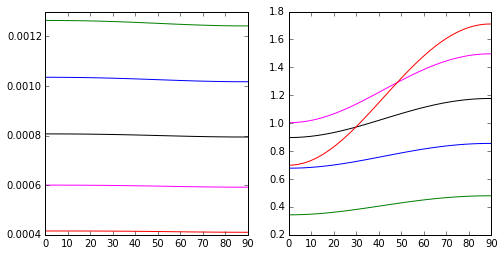

In [112]:
colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

mean_md_df = np.empty(Cross_angle.size)
mean_mk_df = np.empty(Cross_angle.size)

for fsf_i in range(FSF.size):
    for var_i in range(Cross_angle.size):
        mean_md_df[var_i] = np.mean(md_df[fsf_i, var_i, :])
        mean_mk_df[var_i] = np.mean(mk_df[fsf_i, var_i, :])
    axs[0].plot(Cross_angle, mean_md_df, color=colors[fsf_i])  
    axs[1].plot(Cross_angle, mean_mk_df, color=colors[fsf_i])

plt.show()

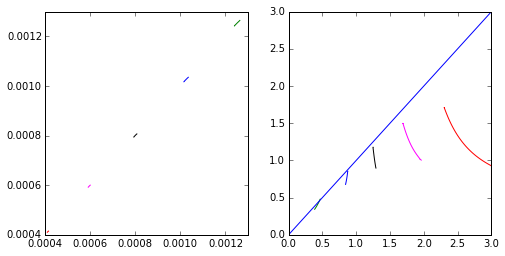

In [113]:
colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

mean_md_df = np.empty(Cross_angle.size)
mean_mk_df = np.empty(Cross_angle.size)

for fsf_i in range(FSF.size):
    for var_i in range(Cross_angle.size):
        mean_md_df[var_i] = np.mean(md_df[fsf_i, var_i, :])
        mean_mk_df[var_i] = np.mean(mk_df[fsf_i, var_i, :])
        mean_md[var_i] = np.mean(md[fsf_i, var_i, :])
        mean_mk[var_i] = np.mean(mk[fsf_i, var_i, :])
    axs[0].plot(mean_md, mean_md_df, color=colors[fsf_i])  
    axs[1].plot(mean_mk, mean_mk_df, color=colors[fsf_i])
axs[1].plot(np.array([0., 3.]), np.array([0., 3.]))  
plt.show()

Process new average technique

In [114]:
params = avs_dki_df(gtab, DWI_simulates)
md_df = params[..., 0]
mk_df = params[..., 1]

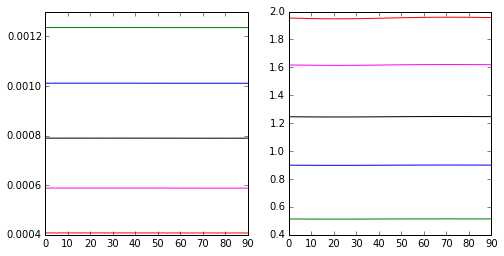

In [115]:
colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

mean_md_df = np.empty(Cross_angle.size)
mean_mk_df = np.empty(Cross_angle.size)

for fsf_i in range(FSF.size):
    for var_i in range(Cross_angle.size):
        mean_md_df[var_i] = np.mean(md_df[fsf_i, var_i, :])
        mean_mk_df[var_i] = np.mean(mk_df[fsf_i, var_i, :])
    axs[0].plot(Cross_angle, mean_md_df, color=colors[fsf_i])  
    axs[1].plot(Cross_angle, mean_mk_df, color=colors[fsf_i])

plt.show()